# 1006개의 데이터로 Transfer_Learning 하기

- 논문의 모델에 1006개의 데이터를 넣고 학습을 시켜보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras.models import Sequential, load_model

import os           
import numpy             as np  
import tensorflow        as tf
import matplotlib.pyplot as plt

#### 필요한 변수들 생성

In [2]:
IMAGE_SIZE = [1024, 1360]                  # 이미지 사이즈 변수
BATCH_SIZE = 32                            # BATCH_SIZE 변수
EPOCHS     = 150                           # EPOCH 크기 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수

#### GPU 사용 여부보기

In [2]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f"Running on multiple GPUs {[gpu.name for gpu in gpus]}")

elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f"Running on single GPU {gpus[0].name}")

else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

Running on single GPU /device:GPU:0
Number of accelerators: 1


## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [4]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel/CellPin")
print(ROOT_PATH)

# 각 데이터 불러오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/train/*/*"))
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/test/*/*"))
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/val/*/*"))

# 데이터 갯수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/aiffel-dj52/aiffel/CellPin
782
104
126


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 355
CPE images count in training set: 427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 50
CPE images count in training set: 76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 40
CPE images count in training set: 64


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 782
Validating images count: 126


#### 라벨 이름들 확인

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['cpe' 'normal']


#### 라벨링 함수를 만들어 보기

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 1)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    
    if label == True:
        label = ([0, 1])
    else:
        label = ([1, 0])
        
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

#### train과 val에 함수들 적용해주기

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [16]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

#### Image shape를 변경 체크하기

In [17]:
for image, label in train_ds.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [18]:
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

In [19]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

        
show_batch(image_batch.numpy(), label_batch)

#### model building(VGG19, Freeze)

In [20]:
with strategy.scope():
    vgg_layer = tf.keras.applications.VGG19(include_top           = False,
                                            weights               = "imagenet",
                                            input_shape           = (256, 256, 3),
                                            classes               = 2,
                                            classifier_activation = "softmax")
    
    fc_layer = [
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(4096),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(4096),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(2),
        tf.keras.layers.Activation("softmax")
    ]

In [22]:
with strategy.scope():
    vgg_layer.trainable = False

vgg_layer.trainable

False

In [23]:
vgg19 = tf.keras.models.Sequential([vgg_layer] + fc_layer)

In [24]:
vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0

## Step 4. 모델 훈련

#### GPU사용하여 model complie

In [27]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    vgg19.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/pre_training_model/best_model_vgg19_1.h5")

#### 모델 fitting

In [28]:
with strategy.scope():
    history = vgg19.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [check_point]
    )

Epoch 1/150
24/24 [==============================] - 163s 6s/step - loss: 4.0028 - accuracy: 0.6549 - precision: 0.6549 - recall: 0.6549 - val_loss: 0.3937 - val_accuracy: 0.8229 - val_precision: 0.8229 - val_recall: 0.8229
Epoch 2/150
24/24 [==============================] - 140s 6s/step - loss: 0.4248 - accuracy: 0.8294 - precision: 0.8294 - recall: 0.8294 - val_loss: 0.3879 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 3/150
24/24 [==============================] - 141s 6s/step - loss: 0.3778 - accuracy: 0.8385 - precision: 0.8385 - recall: 0.8385 - val_loss: 0.3616 - val_accuracy: 0.8646 - val_precision: 0.8646 - val_recall: 0.8646
Epoch 4/150
24/24 [==============================] - 141s 6s/step - loss: 0.3586 - accuracy: 0.8451 - precision: 0.8451 - recall: 0.8451 - val_loss: 0.3494 - val_accuracy: 0.8646 - val_precision: 0.8646 - val_recall: 0.8646
Epoch 5/150
24/24 [==============================] - 140s 6s/step - loss: 0.3643 - accuracy: 0.8568 - pr

24/24 [==============================] - 140s 6s/step - loss: 0.3436 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - val_loss: 0.2811 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 74/150
24/24 [==============================] - 139s 6s/step - loss: 0.3399 - accuracy: 0.8568 - precision: 0.8568 - recall: 0.8568 - val_loss: 0.2200 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271
Epoch 75/150
24/24 [==============================] - 140s 6s/step - loss: 0.3410 - accuracy: 0.8503 - precision: 0.8503 - recall: 0.8503 - val_loss: 0.2687 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 76/150
24/24 [==============================] - 139s 6s/step - loss: 0.3213 - accuracy: 0.8568 - precision: 0.8568 - recall: 0.8568 - val_loss: 0.2459 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 77/150
24/24 [==============================] - 140s 6s/step - loss: 0.2850 - accuracy: 0.8763 - precision:

24/24 [==============================] - 139s 6s/step - loss: 0.2770 - accuracy: 0.8958 - precision: 0.8958 - recall: 0.8958 - val_loss: 0.3913 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 146/150
24/24 [==============================] - 139s 6s/step - loss: 0.2886 - accuracy: 0.8828 - precision: 0.8828 - recall: 0.8828 - val_loss: 0.3186 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 147/150
24/24 [==============================] - 140s 6s/step - loss: 0.2874 - accuracy: 0.8854 - precision: 0.8854 - recall: 0.8854 - val_loss: 0.2394 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 148/150
24/24 [==============================] - 139s 6s/step - loss: 0.2878 - accuracy: 0.8841 - precision: 0.8841 - recall: 0.8841 - val_loss: 0.2711 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 149/150
24/24 [==============================] - 139s 6s/step - loss: 0.3245 - accuracy: 0.8620 - precis

## Step 5. 결과 확인 및 시각화

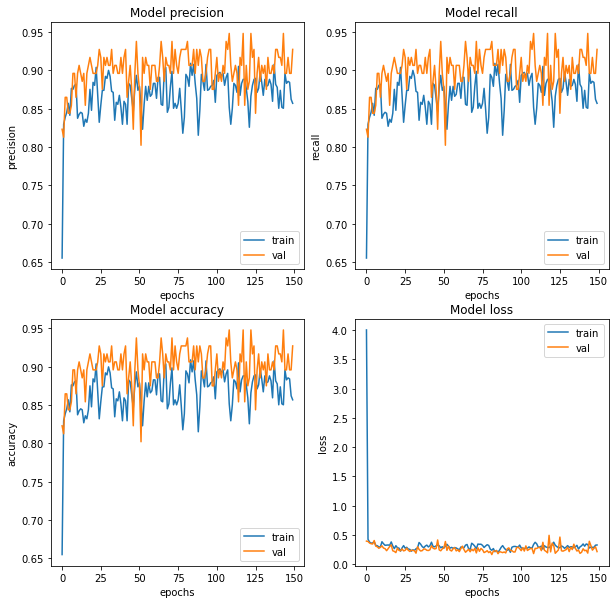

In [29]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Step 6. 최종 Test dataset 검정하기

In [30]:
with strategy.scope():
    vgg19 = tf.keras.models.load_model(ROOT_PATH + "/pre_training_model/best_model_vgg19_1.h5")
    
    loss, acc, prec, rec = vgg19.evaluate(test_ds)

4/4 [==============================] - 14s 3s/step - loss: 0.2297 - accuracy: 0.9231 - precision: 0.9231 - recall: 0.9231


#### model building(VGG19, Fine Tuning)

In [31]:
vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0

In [32]:
with strategy.scope():
    vgg19.layers[0].trainable = True
    
vgg19.layers[0].trainable

True

In [33]:
vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0

In [34]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    vgg19.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/pre_training_model/best_model_vgg19_ft.h5")

In [35]:
with strategy.scope():
    history = vgg19.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks        = [check_point]
    )

Epoch 1/150
24/24 [==============================] - 418s 16s/step - loss: 1.1704 - accuracy: 0.5286 - precision: 0.5286 - recall: 0.5286 - val_loss: 0.5819 - val_accuracy: 0.6771 - val_precision: 0.6771 - val_recall: 0.6771
Epoch 2/150
24/24 [==============================] - 395s 17s/step - loss: 0.5844 - accuracy: 0.7083 - precision: 0.7083 - recall: 0.7083 - val_loss: 0.3883 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 3/150
24/24 [==============================] - 396s 17s/step - loss: 0.4820 - accuracy: 0.7474 - precision: 0.7474 - recall: 0.7474 - val_loss: 0.2488 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 4/150
24/24 [==============================] - 394s 16s/step - loss: 0.4361 - accuracy: 0.7969 - precision: 0.7969 - recall: 0.7969 - val_loss: 0.2681 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 5/150
24/24 [==============================] - 394s 16s/step - loss: 0.3639 - accuracy: 0.8333

24/24 [==============================] - 393s 16s/step - loss: 0.0065 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - val_loss: 0.2950 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 74/150
24/24 [==============================] - 393s 16s/step - loss: 0.0258 - accuracy: 0.9870 - precision: 0.9870 - recall: 0.9870 - val_loss: 0.3024 - val_accuracy: 0.9688 - val_precision: 0.9688 - val_recall: 0.9688
Epoch 75/150
24/24 [==============================] - 392s 16s/step - loss: 0.1316 - accuracy: 0.9727 - precision: 0.9727 - recall: 0.9727 - val_loss: 0.2156 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 76/150
24/24 [==============================] - 392s 16s/step - loss: 0.0680 - accuracy: 0.9740 - precision: 0.9740 - recall: 0.9740 - val_loss: 0.1654 - val_accuracy: 0.9792 - val_precision: 0.9792 - val_recall: 0.9792
Epoch 77/150
24/24 [==============================] - 392s 16s/step - loss: 0.0375 - accuracy: 0.9883 - preci

Epoch 109/150
24/24 [==============================] - 392s 16s/step - loss: 6.5317e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 110/150
24/24 [==============================] - 391s 16s/step - loss: 5.5574e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7146 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 111/150
24/24 [==============================] - 392s 16s/step - loss: 7.5010e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6086 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 112/150
24/24 [==============================] - 392s 16s/step - loss: 3.9335e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6174 - val_accuracy: 0.9583 - val_precision: 0.9583 - val_recall: 0.9583
Epoch 113/150
24/24 [==============================] - 392s 16s/step - loss:

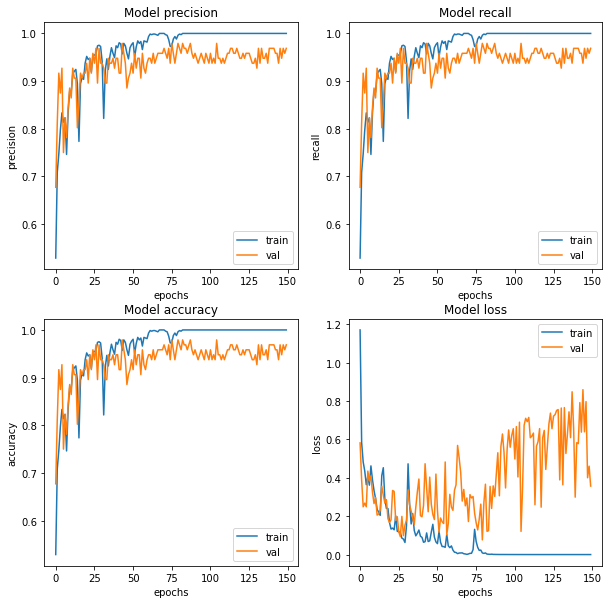

In [36]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [37]:
with strategy.scope():
    vgg19 = tf.keras.models.load_model(ROOT_PATH + "/pre_training_model/best_model_vgg19_ft.h5")
    
    loss, acc, prec, rec = vgg19.evaluate(test_ds)

4/4 [==============================] - 14s 3s/step - loss: 0.4493 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712
